In [1]:
import os
from scipy.io import loadmat
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from fuzzywuzzy import process
from scipy.fft import fft
from scipy.signal import butter, lfilter, find_peaks, peak_widths, filtfilt
from scipy.interpolate import UnivariateSpline
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
import plotly.express as px

data_dir="."

# Data loading and inspection

In [2]:
data_paths = []
data_names = []
for root, dirs, files in os.walk(os.curdir):
    for file in files:
        if file.endswith('.mat'):
            print(file)
            data_paths.append(os.path.join(root, file))
            data_names.append(os.path.basename(os.path.normpath(root)) +file.split('_',1)[1].split('.')[0])
            

filenames = dict(zip(data_names,data_paths))
data ={}

AML_01_3.mat
AML_02_1.mat
AML_02_3.mat
AML_02_2.mat
AML_01_1.mat
AML_01_2.mat
DM002_TDM_1kmh_NoEES.mat
DM002_TDM_08_2kmh.mat
DM002_TDM_08_1kmh.mat


In [3]:
filenames

{'Helathy_data01_3': './Helathy_data/AML_01_3.mat',
 'Helathy_data02_1': './Helathy_data/AML_02_1.mat',
 'Helathy_data02_3': './Helathy_data/AML_02_3.mat',
 'Helathy_data02_2': './Helathy_data/AML_02_2.mat',
 'Helathy_data01_1': './Helathy_data/AML_01_1.mat',
 'Helathy_data01_2': './Helathy_data/AML_01_2.mat',
 'SCI HumanTDM_1kmh_NoEES': './SCI Human/DM002_TDM_1kmh_NoEES.mat',
 'SCI HumanTDM_08_2kmh': './SCI Human/DM002_TDM_08_2kmh.mat',
 'SCI HumanTDM_08_1kmh': './SCI Human/DM002_TDM_08_1kmh.mat'}

In [4]:
data = {}
def load_file(field):
    if field in data:
        print(f"Already loaded {field}. Try `data[{field}]` to access the data")
    else:
        print(f"Reading {filenames[field]}")
        try:
            data[field] = loadmat(f"{data_dir}/{filenames[field]}")
        except IOError as e:
            print(f"Failed reading {filenames[field]}:\n\t{e}")
    return data[field].keys()


def load_files(list):
    for file in list:
        load_file(file)

In [5]:
load_files(filenames)

Reading ./Helathy_data/AML_01_3.mat
Reading ./Helathy_data/AML_02_1.mat
Reading ./Helathy_data/AML_02_3.mat
Reading ./Helathy_data/AML_02_2.mat
Reading ./Helathy_data/AML_01_1.mat
Reading ./Helathy_data/AML_01_2.mat
Reading ./SCI Human/DM002_TDM_1kmh_NoEES.mat
Reading ./SCI Human/DM002_TDM_08_2kmh.mat
Reading ./SCI Human/DM002_TDM_08_1kmh.mat


In [6]:
data["Helathy_data02_1"]

{'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Wed May 18 11:13:09 2022',
 '__version__': '1.0',
 '__globals__': [],
 'EMG': array([[(array([[ 1.02689455e-07],
                [ 6.32971648e-07],
                [ 2.85662658e-08],
                ...,
                [-7.31085674e-06],
                [-6.18491140e-06],
                [-5.73973875e-06]]), array([[-2.40595145e-05],
                [-2.38730172e-05],
                [-2.37584190e-05],
                ...,
                [-2.33910705e-05],
                [-2.38395442e-05],
                [-2.39358305e-05]]), array([[3.86053262e-06],
                [3.86053262e-06],
                [3.78863228e-06],
                ...,
                [5.63860885e-06],
                [5.22311166e-06],
                [4.83501799e-06]]), array([[-3.47629566e-06],
                [-3.57740714e-06],
                [-3.63359709e-06],
                ...,
                [-1.24861781e-05],
                [-8.077841

In [7]:
#common muscles
n1 = set(data["Helathy_data01_1"]["EMG"].dtype.names)
n2 = set(data["SCI HumanTDM_1kmh_NoEES"]["data"].dtype.names)
n3 = set(data["SCI HumanTDM_08_2kmh"]["data"].dtype.names)
n4 = set(data["SCI HumanTDM_08_1kmh"]["data"].dtype.names)

ls = [n1,n2,n3,n4]
common = ls[0].intersection(*ls)
common

{'LRF', 'LST', 'LSol', 'LTA', 'RRF', 'RST', 'RSol', 'RTA'}

In [8]:
#common markers
m1 = set(data["Helathy_data01_1"]["Markers"].dtype.names)
m2 = set(data["SCI HumanTDM_1kmh_NoEES"]["data"].dtype.names)
m3 = set(data["SCI HumanTDM_08_2kmh"]["data"].dtype.names)
m4 = set(data["SCI HumanTDM_08_1kmh"]["data"].dtype.names)

lss = [m1,m2,m3,m4]
common2 = lss[0].intersection(*lss)
common2

{'LANK', 'LHIP', 'LKNE', 'LTOE', 'RANK', 'RHIP', 'RKNE', 'RTOE'}

After looking at the muscles in common in a few files, one can notice there are missing a few ones (e.g. Iliopsoas). This is because some muscles names in the data are slightly different (e.g LIl in Helathy_data01_1 and LIL in SCI HumanTDM_1kmh_NoEES...). 

## 1. EMG data
First, transform the EMG data structure into an easier one to work with

In [9]:
part_names = data["Helathy_data01_1"]["EMG"].dtype.names
data_EMG = {name : pd.DataFrame({
    part: list(data[name]["EMG"][part][0][0][:,0]) for part in part_names})
            if "EMG" in data[name].keys() 
            else pd.DataFrame({
    part: list(data[name]["data"][process.extractOne(part, list(data[name]["data"].dtype.names))[0]] [0][0][:,0]) 
    for part in part_names if process.extractOne(part, list(data[name]["data"].dtype.names))[1] > 60})
        for name in data_names}

In [10]:
for name in filenames:
    print(data_EMG[name].columns)

Index(['LIl', 'LRF', 'LVlat', 'LST', 'LTA', 'LSol', 'LGM', 'RIl', 'RRF',
       'RVlat', 'RST', 'RTA', 'RSol', 'RGM'],
      dtype='object')
Index(['LIl', 'LRF', 'LVlat', 'LST', 'LTA', 'LSol', 'LGM', 'RIl', 'RRF',
       'RVlat', 'RST', 'RTA', 'RSol', 'RGM'],
      dtype='object')
Index(['LIl', 'LRF', 'LVlat', 'LST', 'LTA', 'LSol', 'LGM', 'RIl', 'RRF',
       'RVlat', 'RST', 'RTA', 'RSol', 'RGM'],
      dtype='object')
Index(['LIl', 'LRF', 'LVlat', 'LST', 'LTA', 'LSol', 'LGM', 'RIl', 'RRF',
       'RVlat', 'RST', 'RTA', 'RSol', 'RGM'],
      dtype='object')
Index(['LIl', 'LRF', 'LVlat', 'LST', 'LTA', 'LSol', 'LGM', 'RIl', 'RRF',
       'RVlat', 'RST', 'RTA', 'RSol', 'RGM'],
      dtype='object')
Index(['LIl', 'LRF', 'LVlat', 'LST', 'LTA', 'LSol', 'LGM', 'RIl', 'RRF',
       'RVlat', 'RST', 'RTA', 'RSol', 'RGM'],
      dtype='object')
Index(['LIl', 'LRF', 'LVlat', 'LST', 'LTA', 'LSol', 'LGM', 'RIl', 'RRF',
       'RVlat', 'RST', 'RTA', 'RSol', 'RGM'],
      dtype='object')
Index(['LIl',

Looking at sampling frequencies

In [11]:
EMG_freqs = {}
for name in data_names:
    if not name.startswith("SCI"):
        EMG_freqs[name] =  data[name]["Info"]["EMGfq"][0][0][0][0]
    else:
        EMG_freqs[name] = data[name]["data"]["EMG_sr"][0][0][0][0]

## Preprocessing EMG data
Transform the raw data by filtering it into a format that is more suitable for further analysis such as features extraction to create EMG parameters for the PCA. First, let's define a few functions

In [12]:
def plot_data(data, fs, start=100000, end=120000):
    x_axis = np.linspace(0, np.int_(data.size/fs), data.size)
    plt.plot(x_axis[start:end], data[start:end])
    plt.xlabel('Time [s]')
    plt.ylabel('Amplitude [V]')

In [13]:
#plots the signal in frequency domain
def plot_power_spectrum(data, fs):
    N = len(data) # length of the signal
    T = 1.0/fs
    xf = np.linspace(0.0, 1.0/(2.0*T), int(N/2))
    Y = np.fft.fft(data)

    Y_freq = 2.0/N * np.abs(Y[0:int(N/2)])[1:]
    x_freq = xf[1:]
    plt.rcParams["figure.figsize"] = (17, 5)
    plt.plot(x_freq, Y_freq)
    plt.xlabel('Frequency [Hz]')
    plt.ylabel('Power')

In [14]:
#Bandpass filter
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

In [15]:
#low pass filter
def butter_lowpass(cutoff, fs, order=5):
    return butter(order, cutoff, fs=fs, btype='low', analog=False)

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y

def butter_lowpass_filter2(data, fs, cutoff=3):
    low_pass = cutoff/(fs/2)
    b, a = butter(4, low_pass, btype='lowpass')
    y = filtfilt(b, a, data)
    return y

In [16]:
#Filter the data
def filter_EMG(data, fs):
    filtered_EMG = butter_bandpass_filter(data, 10, fs/2 - 5, fs)
    #Rectification (absolute value)
    filtered_EMG = np.abs(filtered_EMG)
    # Lowpass filter applied to rectified signal to get EMG envelope
    filtered_EMG = butter_lowpass_filter2(filtered_EMG, fs)
    #replace nan values
    filtered_EMG = np.nan_to_num(filtered_EMG)

    return filtered_EMG

Plot raw EMG data in time and frequency domains.

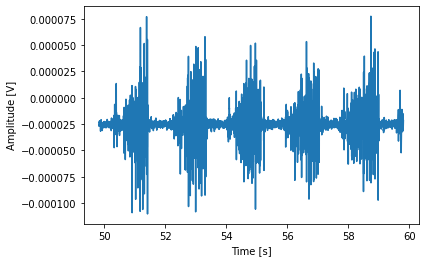

In [17]:
plot_data(data_EMG['Helathy_data01_1']['RSol'], EMG_freqs['Helathy_data01_1'])
healthy = filter_EMG(data_EMG['Helathy_data01_1']['RSol'], EMG_freqs['Helathy_data01_1'])

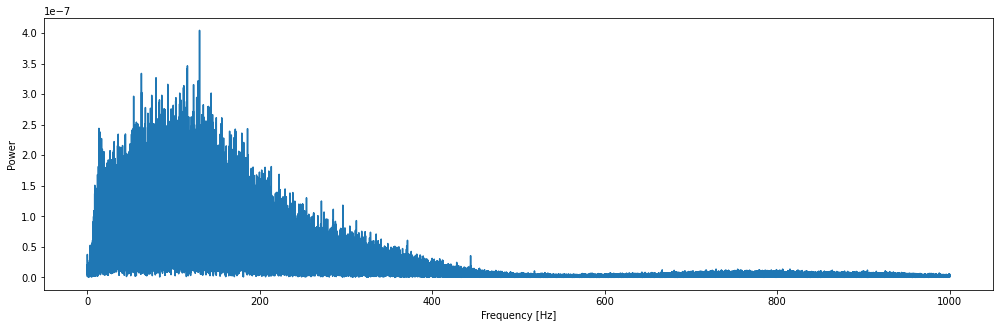

In [18]:
plot_power_spectrum(data_EMG["Helathy_data01_1"]["RSol"], EMG_freqs["Helathy_data01_1"])

Then, plot the corresponding filtered EMG data in time and frequency domains

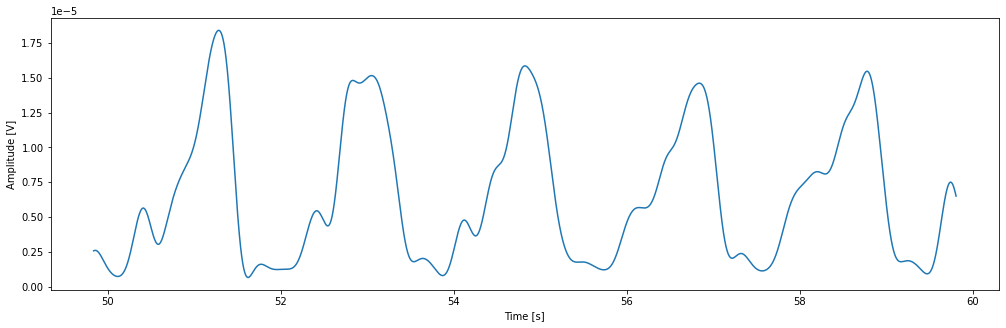

In [19]:
plot_data(healthy, EMG_freqs['Helathy_data01_1'])

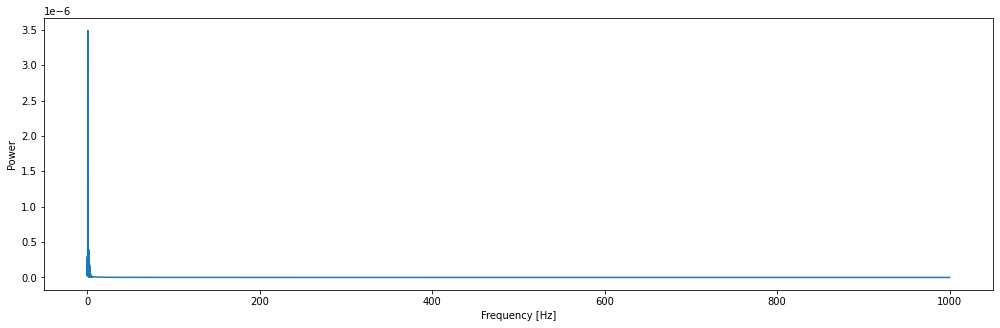

In [20]:
plot_power_spectrum(healthy, EMG_freqs['Helathy_data01_1'])

Now that the preprocessing gives the linear envelope, let's filter all the raw EMG data.

In [21]:
new_EMG_data ={}
for data_file in data_EMG.keys():
    new_EMG_data[data_file] = {}
    for muscle in data_EMG['Helathy_data01_3'].keys():
        new_EMG_data[data_file][muscle] = {}
        if data_file == 'SCI HumanTDM_08_1kmh' or data_file == 'SCI HumanTDM_08_2kmh':
            new_EMG_data[data_file][muscle] = filter_EMG(data_EMG[data_file][muscle]*1e-4,EMG_freqs[data_file])
        else:
            new_EMG_data[data_file][muscle] = filter_EMG(data_EMG[data_file][muscle],EMG_freqs[data_file])
    
new_EMG_data = pd.DataFrame(new_EMG_data)

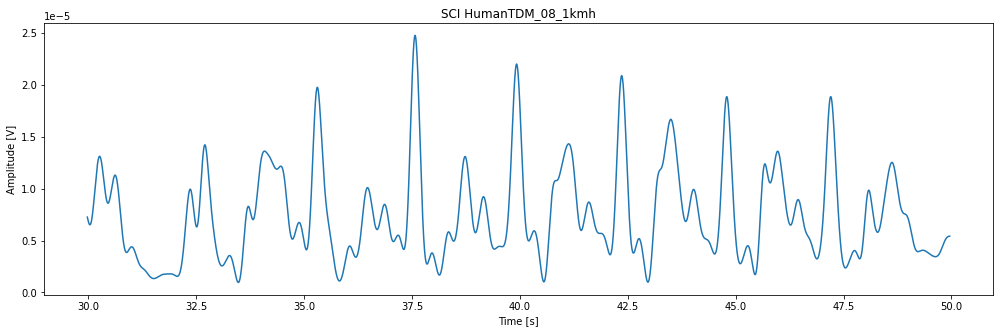

In [22]:
for name in new_EMG_data.keys():
    plt.figure()
    plt.title(name)
    plot_data(new_EMG_data[name]['RSol'], EMG_freqs[name], 30000, 50000)

## EMG parameters
Now that the EMG has been preprocessed, it is time to extract the EMG parameters

### Burst onset/end of muscle

In [23]:
#returns number of burst onsets and ends 
def find_onsets_ends(data):
    ind_peaks, _ = find_peaks(data)
    duration, _, onsets, ends = peak_widths(x = data, peaks = ind_peaks, rel_height= 0.9)
    n_onsets = onsets.size
    n_ends = ends.size
    return [n_onsets, n_ends]

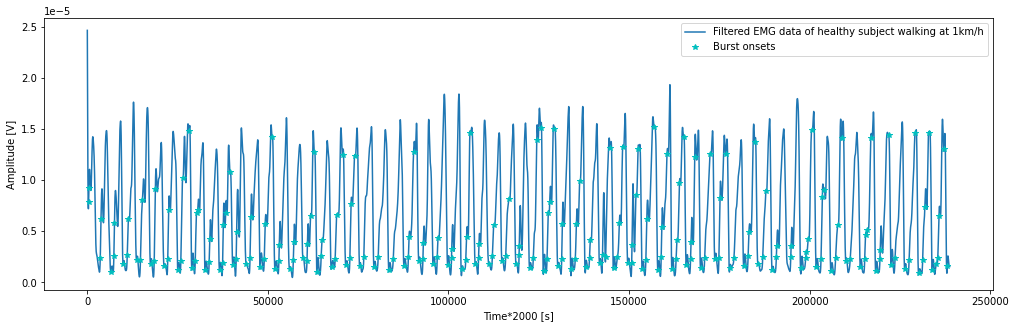

In [24]:
ind_peaks, _ = find_peaks(healthy)
duration, _, onsets, ends = peak_widths(x = healthy, peaks = ind_peaks, rel_height= 0.9)
onsets = np.int_(onsets)
plt.rcParams["figure.figsize"] = (17, 5)
plt.plot(healthy)
plt.plot(onsets, healthy[onsets], '*c')
plt.ylabel('Amplitude [V]')
plt.xlabel('Time*2000 [s]')
plt.legend(['Filtered EMG data of healthy subject walking at 1km/h', 'Burst onsets'])

### Mean amplitude of muscle

In [25]:
def param_mean_ampl(data):
    indices = find_peaks(data)[0]
    if len(indices) == 0:
        return 0
    else:
        mean_amplitude = np.mean(data[indices])
        return mean_amplitude

## Kinematic data
Markers position of the hip, knee, ankle and toe in the x, y and z position. As in the EMG part, transform the kinematic data structure into an easier one to work with.

In [26]:
m1 = set(data["Helathy_data01_1"]["Markers"].dtype.names)
m2 = set(data["SCI HumanTDM_1kmh_NoEES"]["data"].dtype.names)
m3 = set(data["SCI HumanTDM_08_2kmh"]["data"].dtype.names)
m4 = set(data["SCI HumanTDM_08_1kmh"]["data"].dtype.names)

lss = [m1,m2,m3,m4]
marker_names = lss[0].intersection(*lss)
marker_names

{'LANK', 'LHIP', 'LKNE', 'LTOE', 'RANK', 'RHIP', 'RKNE', 'RTOE'}

In [27]:
data_kin = {}
for d_name in data_names:
    data_kin[d_name] = {}
    #for helathy data files
    if "Markers" in data[d_name].keys():
        for m_name in marker_names:
            data_kin[d_name][m_name] = {}
            data_kin[d_name][m_name] = data[d_name]["Markers"][0][0][m_name]
    #for SCI data files
    else: 
        for m_name in marker_names:
            data_kin[d_name][m_name] = {}
            data_kin[d_name][m_name] = data[d_name]["data"][m_name][0][0]

data_kin = pd.DataFrame(data_kin)

### Gait events detection by visual inspection of data

In [28]:
#Find the angle between 3 markers
def find_angle(a, b, c):
    ba = a - b
    bc = c - b

    #Normalizing rows
    ba = (ba.T / np.linalg.norm(ba,axis=1)).T
    bc = (bc.T / np.linalg.norm(bc,axis=1)).T

    angle = np.degrees(np.arccos(-np.sum(ba*bc, axis=1)))
    return angle

In [29]:
knee11 = find_angle(data_kin["Helathy_data01_1"]["RHIP"], data_kin["Helathy_data01_1"]["RKNE"], data_kin["Helathy_data01_1"]["RANK"])
knee12 = find_angle(data_kin["Helathy_data01_2"]["RHIP"], data_kin["Helathy_data01_2"]["RKNE"], data_kin["Helathy_data01_2"]["RANK"])
knee13 = find_angle(data_kin["Helathy_data01_3"]["RHIP"], data_kin["Helathy_data01_3"]["RKNE"], data_kin["Helathy_data01_3"]["RANK"])
knee21 = find_angle(data_kin["Helathy_data02_1"]["RHIP"], data_kin["Helathy_data02_1"]["RKNE"], data_kin["Helathy_data02_1"]["RANK"])
knee22 = find_angle(data_kin["Helathy_data02_2"]["RHIP"], data_kin["Helathy_data02_2"]["RKNE"], data_kin["Helathy_data02_2"]["RANK"])
knee23 = find_angle(data_kin["Helathy_data02_3"]["RHIP"], data_kin["Helathy_data02_3"]["RKNE"], data_kin["Helathy_data02_3"]["RANK"])
kneeSCI_noEES = find_angle(data_kin["SCI HumanTDM_1kmh_NoEES"]["RHIP"], data_kin["SCI HumanTDM_1kmh_NoEES"]["RKNE"], data_kin["SCI HumanTDM_1kmh_NoEES"]["RANK"])
kneeSCI_EES = find_angle(data_kin["SCI HumanTDM_08_1kmh"]["RHIP"], data_kin["SCI HumanTDM_08_1kmh"]["RKNE"], data_kin["SCI HumanTDM_08_1kmh"]["RANK"])
kneeSCI_EES2 = find_angle(data_kin["SCI HumanTDM_08_2kmh"]["RHIP"], data_kin["SCI HumanTDM_08_2kmh"]["RKNE"], data_kin["SCI HumanTDM_08_2kmh"]["RANK"])

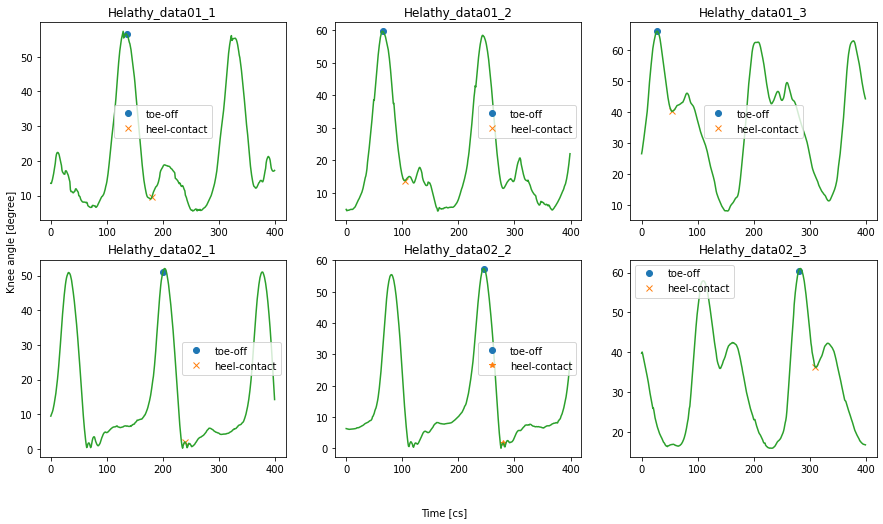

In [30]:
fig, axs = plt.subplots(2, 3, squeeze = False, figsize = (15, 8))

axs[0, 0].plot(135, knee11[135], 'o')
axs[0, 0].plot(180, knee11[180], 'x')
axs[0, 0].legend(['toe-off', 'heel-contact'])
axs[0, 0].plot(knee11[0:400])
axs[0, 0].set_title('Helathy_data01_1')
axs[0, 1].plot(65, knee12[65], 'o')
axs[0, 1].plot(105, knee12[105], 'x')
axs[0, 1].legend(['toe-off', 'heel-contact'])
axs[0, 1].plot(knee12[0:400])
axs[0, 1].set_title('Helathy_data01_2')
axs[0, 2].plot(27, knee13[27], 'o')
axs[0, 2].plot(55, knee13[55], 'x')
axs[0, 2].legend(['toe-off', 'heel-contact'])
axs[0, 2].plot(knee13[0:400])
axs[0, 2].set_title('Helathy_data01_3')
axs[1, 0].plot(200, knee21[200], 'o')
axs[1, 0].plot(240, knee21[240], 'x')
axs[1, 0].legend(['toe-off', 'heel-contact'])
axs[1, 0].plot(knee21[0:400])
axs[1, 0].set_title('Helathy_data02_1')
axs[1, 1].plot(245, knee22[245], 'o')
axs[1, 1].plot(280, knee22[280], '*')
axs[1, 1].legend(['toe-off', 'heel-contact'])
axs[1, 1].plot(knee22[0:400])
axs[1, 1].set_title('Helathy_data02_2')
axs[1, 2].plot(280, knee23[280], 'o')
axs[1, 2].plot(310, knee23[310], 'x')
axs[1, 2].legend(['toe-off', 'heel-contact'])
axs[1, 2].plot(knee23[0:400])
axs[1, 2].set_title('Helathy_data02_3')

fig.text(0.5, 0.025, 'Time [cs]', ha='center')
fig.text(0.095, 0.5, 'Knee angle [degree]', va='center', rotation='vertical')

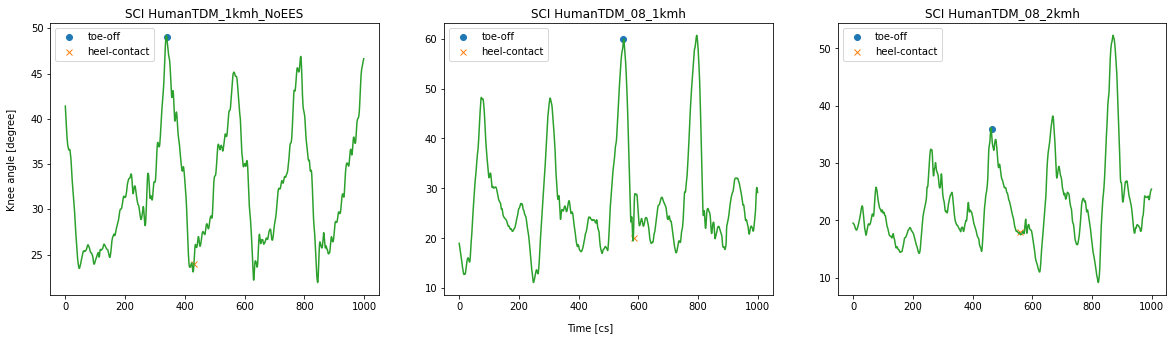

In [31]:
fig, axs = plt.subplots(1, 3, squeeze = False, figsize = (20, 5))
axs[0, 0].plot(340, 49, 'o')
axs[0, 0].plot(430, 24, 'x')
axs[0, 0].legend(['toe-off', 'heel-contact'])
axs[0, 0].plot(kneeSCI_noEES[1000:2000])
axs[0, 0].set_title('SCI HumanTDM_1kmh_NoEES')
axs[0, 1].plot(550, 60, 'o')
axs[0, 1].plot(585, 20, 'x')
axs[0, 1].legend(['toe-off', 'heel-contact'])
axs[0, 1].plot(kneeSCI_EES[3500:4500])
axs[0, 1].set_title('SCI HumanTDM_08_1kmh')
axs[0, 2].plot(465, 36, 'o')
axs[0, 2].plot(560, 18, 'x')
axs[0, 2].legend(['toe-off', 'heel-contact'])
axs[0, 2].plot(kneeSCI_EES2[2500:3500])
axs[0, 2].set_title('SCI HumanTDM_08_2kmh')
fig.text(0.5, 0.025, 'Time [cs]', ha='center')
fig.text(0.095, 0.5, 'Knee angle [degree]', va='center', rotation='vertical')

plt.figure(figsize = (5, 7))

## Automatic detection of gait events 

### Normal gait

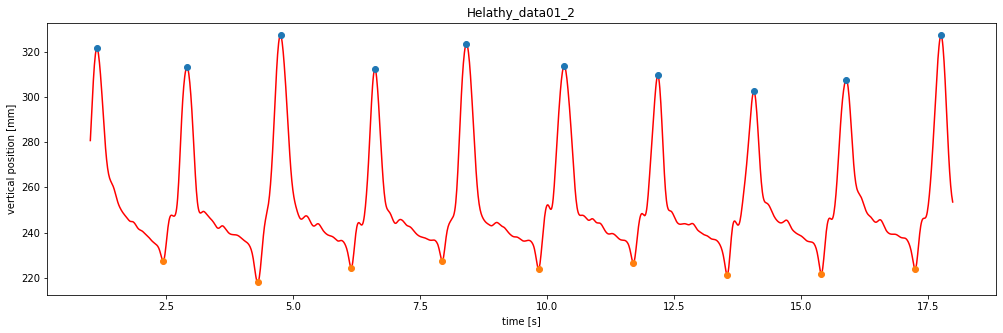

In [32]:
gait_events = {}
for name in filenames:
    if name.startswith("H"):
        filtered_ltoe = butter_lowpass_filter(data_kin[name]["LTOE"][:,2],5,100,order=4)
        filtered_rtoe = butter_lowpass_filter(data_kin[name]["RTOE"][:,2],5,100,order=4)
        time = np.linspace(0,len(filtered_ltoe) * (1/100), len(filtered_ltoe))
        interp_ltoe =  UnivariateSpline(time,filtered_ltoe,k=5,s = 1)
        interp_rtoe =  UnivariateSpline(time,filtered_rtoe,k=5,s = 1)

        peaks_l = find_peaks(interp_ltoe(time), height=275, distance=50)
        valley_l = find_peaks(-interp_ltoe(time), distance=50, prominence=5)

        peaks_r = find_peaks(interp_rtoe(time), height=275, distance=50)
        valley_r = find_peaks(-interp_rtoe(time), distance=50, prominence=5)

        # Since left and right is inverted we have to account for that here

        if name == "Helathy_data02_1" or name == "Helathy_data02_2":
            gait_events[name] = {"LIC": time[peaks_r[0]],
                                "LTO": time[valley_r[0]],
                                "RIC": time[peaks_l[0]],
                                "RTO": time[valley_l[0]]}
        else:
            gait_events[name] = {"LIC": time[peaks_l[0]],
                                "LTO": time[valley_l[0]],
                                "RIC": time[peaks_r[0]],
                                "RTO": time[valley_r[0]]}
        
        
        # Visual inspection
        plt.figure()
        plt.title(name)
        plt.xlabel("time [s]")
        plt.ylabel("vertical position [mm]")
        plt.plot(time[100:1800], interp_rtoe(time[100:1800]),'r')
        peaks = find_peaks(interp_rtoe(time[100:1800]), height=275, distance=50)
        valley = find_peaks(-interp_rtoe(time[100:1800]), distance=50, prominence=5)
        plt.plot(time[100:1800][peaks[0]], interp_rtoe(time[100:1800])[peaks[0]] , 'o')
        plt.plot(time[100:1800][valley[0]], interp_rtoe(time[100:1800])[valley[0]] , 'o')
        plt.show()



### SCI gait

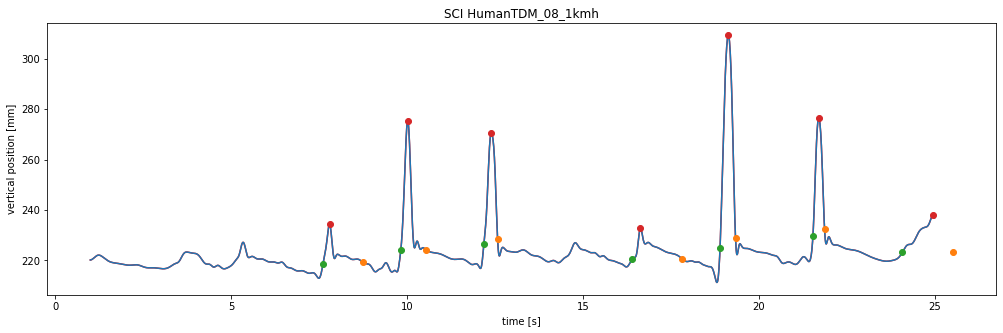

In [33]:
from scipy.signal import find_peaks, peak_widths

for name in filenames:
    if not name.startswith("H"):
        if not name.endswith("NoEES"):
            filtered_ltoe = butter_lowpass_filter(data_kin[name]["LTOE"][:,2],5,100,order=4)
            filtered_rtoe = butter_lowpass_filter(data_kin[name]["RTOE"][:,2],5,100,order=4)
            time_l = np.linspace(0,len(filtered_ltoe) * (1/100), len(filtered_ltoe))
            time_r = np.linspace(0,len(filtered_rtoe) * (1/100), len(filtered_rtoe))
            interp_ltoe =  UnivariateSpline(time_l,filtered_ltoe,k=5,s = 100)
            interp_rtoe =  UnivariateSpline(time_r,filtered_rtoe,k=5,s = 100)

            peaks_l = find_peaks(interp_ltoe(time_l), height=220, distance=75, prominence=15, width = (5,110))
            peaks_r = find_peaks(interp_rtoe(time_r), height=220, distance=75, prominence=15, width = (5,110))
        

            wl = peak_widths(interp_ltoe(time_l), peaks_l[0], rel_height=0.8)
            wr = peak_widths(interp_rtoe(time_r), peaks_r[0],  rel_height=0.8)


            gait_events[name] = {"LIC": time_l[wl[3].astype(int)],
                                "LTO": time_l[wl[2].astype(int)],
                                "RIC": time_r[wr[3].astype(int)],
                                "RTO": time_r[wr[2].astype(int)]}
        
 
            plt.figure()
            plt.title(name)
            plt.xlabel("time [s]")
            plt.ylabel("vertical position [mm]")
            plt.plot(time_r[100:2500], interp_rtoe(time_r[100:2500]),'r')
            plt.plot(time_r[100:2500],interp_rtoe(time_r[100:2500]))
            plt.plot(gait_events[name]["RIC"][1:8], interp_rtoe(gait_events[name]["RIC"][1:8]),'o')
            plt.plot(gait_events[name]["RTO"][1:8], interp_rtoe(gait_events[name]["RTO"][1:8]),'o')
            plt.plot(time_r[peaks_r[0][1:8]], interp_rtoe(time_r[peaks_r[0][1:8]]), 'o')
            plt.show()

        else:
            filtered_ltoe = butter_lowpass_filter(data_kin[name]["LTOE"][:,2],5,100,order=4)
            filtered_rtoe = butter_lowpass_filter(data_kin[name]["RTOE"][:,2],5,100,order=4)
            time_l = np.linspace(0,len(filtered_ltoe) * (1/100), len(filtered_ltoe))
            time_r = np.linspace(0,len(filtered_rtoe) * (1/100), len(filtered_rtoe))
            interp_ltoe =  UnivariateSpline(time_l,filtered_ltoe,k=5,s = 100)
            interp_rtoe =  UnivariateSpline(time_r,filtered_rtoe,k=5,s = 100)

            peaks_l = find_peaks(interp_ltoe(time_l), height=20, distance=75, prominence=15, width = (5,75))
            peaks_r = find_peaks(interp_rtoe(time_r), height=20, distance=75, prominence=15, width = (5,75))
        

            wl = peak_widths(interp_ltoe(time_l), peaks_l[0], rel_height=0.8)
            wr = peak_widths(interp_rtoe(time_r), peaks_r[0],  rel_height=0.8)


            gait_events[name] = {"LIC": time_l[wl[3].astype(int)],
                                "LTO": time_l[wl[2].astype(int)],
                                "RIC": time_r[wr[3].astype(int)],
                                "RTO": time_r[wr[2].astype(int)]}
        
 
            plt.figure()
            plt.title(name)
            plt.xlabel("time [s]")
            plt.ylabel("vertical position [mm]")
            plt.plot(time_r[100:2500], interp_rtoe(time_r[100:2500]),'r')
            plt.plot(time_r[100:2500],interp_rtoe(time_r[100:2500]))
            plt.plot(gait_events[name]["RIC"][1:8], interp_rtoe(gait_events[name]["RIC"][1:8]),'o')
            plt.plot(gait_events[name]["RTO"][1:8], interp_rtoe(gait_events[name]["RTO"][1:8]),'o')
            plt.plot(time_r[peaks_r[0][1:8]], interp_rtoe(time_r[peaks_r[0][1:8]]), 'o')
            plt.show()
            

## Computing all parameters
Compute all parameters in a suitable way to give to PCA algorithm.

Kinematic parameters :

- Swing duration
- Stance duration
- max knee joint angle
- max hip joint angle 
- max ankle joint angle
- min knew joint angle
- min hip joint angle 
- min ankle joint angle
- ankle joint angular velocity
- foot oscillation

In [34]:
def get_knee_angle(name):
    return find_angle(data_kin[name]["LHIP"], data_kin[name]["LKNE"], data_kin[name]["LANK"]), find_angle(data_kin[name]["RHIP"], data_kin[name]["RKNE"], data_kin[name]["RANK"])

def get_hip_angle(name):
    return find_angle(np.array(len(data_kin[name]["LHIP"])*[[0,0,1]]), data_kin[name]["LHIP"], data_kin[name]["LKNE"]),find_angle(np.array(len(data_kin[name]["RHIP"])*[[0,0,1]]), data_kin[name]["RHIP"], data_kin[name]["RKNE"])

def get_ankle_angle(name):
    return find_angle(data_kin[name]["LKNE"], data_kin[name]["LANK"], data_kin[name]["LTOE"]), find_angle(data_kin[name]["RKNE"], data_kin[name]["RANK"], data_kin[name]["RTOE"])

def get_ankle_angle_v(name):
    angles_l, angles_r = get_ankle_angle(name)
    return [0]+[abs(j-i) * (1/100) for i,j in zip(angles_l[:-1],angles_l[1:])], [0]+[abs(j-i) * (1/100) for i,j in zip(angles_r[:-1],angles_r[1:])]

def apply_on_time_window(fun ,data, lower, upper, fs, onsets_ends = False):
    lower_index = lower / (1/fs)
    upper_index = upper / (1/fs)
    if onsets_ends == False :
        return fun(data[int(lower_index):int(upper_index)])
    else:
        return fun(data[int(lower_index):int(upper_index)], fs)
    
def align_to_ic(l1,l2):
    r1 = []
    r2 = []
    if l1[0] < l2[0]:
        for e1, e2 in zip(l1,l2):
            if e1 < e2:
                r1.append(e1)
                r2.append(e2)
            else: print("Alignment problem")
                
    elif l1[0] > l2[0]:
        for e1, e2 in zip(l1,l2[1:]):
            if e1 < e2:
                r1.append(e1)
                r2.append(e2)
            else: print("Alignment problem")
                
    else:
        align_to_ic(l1[1:],l2[1:])

    return r1,r2

In [35]:
pca_parameters = {}
for name in filenames:
    l = align_to_ic(gait_events[name]["LTO"],gait_events[name]["LIC"])
    r = align_to_ic(gait_events[name]["RTO"],gait_events[name]["RIC"])
    lto,lic = np.array(l[0]), np.array(l[1])
    rto,ric = np.array(r[0]), np.array(r[1])
    
    # Calculating swing and stance durations
    pca_parameters[name] = {}
    pca_parameters[name]["L"] = {"swing_duration" : (lic - lto)[:-1], "stance_duration" : lto[1:] - lic[:-1]}
    pca_parameters[name]["R"] = {"swing_duration" : (ric - rto)[:-1], "stance_duration" : rto[1:] - ric[:-1]}

    # Calculating max and min angles
    lkne,rkne = get_knee_angle(name)
    lank,rank = get_ankle_angle(name)
    lhip,rhip = get_hip_angle(name)

    pca_parameters[name]["L"]["max_knee_angle"] =  [apply_on_time_window(np.max,lkne,i,j,100) for i,j in zip(lto[:-1],lto[1:])]
    pca_parameters[name]["L"]["min_knee_angle"] =  [apply_on_time_window(np.min,lkne,i,j,100) for i,j in zip(lto[:-1],lto[1:])]
    pca_parameters[name]["L"]["max_ankle_angle"] =  [apply_on_time_window(np.max,lank,i,j,100) for i,j in zip(lto[:-1],lto[1:])]
    pca_parameters[name]["L"]["min_ankle_angle"] =  [apply_on_time_window(np.min,lank,i,j,100) for i,j in zip(lto[:-1],lto[1:])]
    pca_parameters[name]["L"]["max_hip_angle"] =  [apply_on_time_window(np.max,lhip,i,j,100) for i,j in zip(lto[:-1],lto[1:])]
    pca_parameters[name]["L"]["min_hip_angle"] =  [apply_on_time_window(np.min,lhip,i,j,100) for i,j in zip(lto[:-1],lto[1:])]

    pca_parameters[name]["R"]["max_knee_angle"] =  [apply_on_time_window(np.max,rkne,i,j,100) for i,j in zip(rto[:-1],rto[1:])]
    pca_parameters[name]["R"]["min_knee_angle"] =  [apply_on_time_window(np.min,rkne,i,j,100) for i,j in zip(rto[:-1],rto[1:])]
    pca_parameters[name]["R"]["max_ankle_angle"] =  [apply_on_time_window(np.max,rank,i,j,100) for i,j in zip(rto[:-1],rto[1:])]
    pca_parameters[name]["R"]["min_ankle_angle"] =  [apply_on_time_window(np.min,rank,i,j,100) for i,j in zip(rto[:-1],rto[1:])]
    pca_parameters[name]["R"]["max_hip_angle"] =  [apply_on_time_window(np.max,rhip,i,j,100) for i,j in zip(rto[:-1],rto[1:])]
    pca_parameters[name]["R"]["min_hip_angle"] =  [apply_on_time_window(np.min,rhip,i,j,100) for i,j in zip(rto[:-1],rto[1:])]

    pca_parameters[name]["L"]["var_foot"] =  [apply_on_time_window(np.var,lank,i,j,100) for i,j in zip(lto[:-1],lto[1:])]
    pca_parameters[name]["R"]["var_foot"] = [apply_on_time_window(np.var,rank,i,j,100) for i,j in zip(rto[:-1],rto[1:])]

    pca_parameters[name]["L"]["max_ankle_anlge_v"] = [apply_on_time_window(np.max,get_ankle_angle_v(name)[0],i,j,100) for i,j in zip(lto[:-1],lto[1:])]
    pca_parameters[name]["R"]["max_ankle_anlge_v"] = [apply_on_time_window(np.max,get_ankle_angle_v(name)[1],i,j,100) for i,j in zip(rto[:-1],rto[1:])]


    pca_parameters[name]["L"]["label"] = [name + "_L" for i,j in zip(lto[:-1],lto[1:])]
    pca_parameters[name]["R"]["label"] = [name + "_R" for i,j in zip(rto[:-1],rto[1:])]

    pca_parameters[name]["L"]["foot"] = ["L" for i,j in zip(lto[:-1],lto[1:])]
    pca_parameters[name]["R"]["foot"] = ["R" for i,j in zip(rto[:-1],rto[1:])]

    if name.startswith("H"):
        pca_parameters[name]["L"]["condition"] = ["Healthy" for i,j in zip(lto[:-1],lto[1:])]
        pca_parameters[name]["R"]["condition"] = ["Healthy" for i,j in zip(rto[:-1],rto[1:])]
    else:
        pca_parameters[name]["L"]["condition"] = ["SCI injury" for i,j in zip(lto[:-1],lto[1:])]
        pca_parameters[name]["R"]["condition"] = ["SCI injury" for i,j in zip(rto[:-1],rto[1:])]

    #EMG parameters

    pca_parameters[name]["R"]["burst_onset_Sol"] = [apply_on_time_window(find_onsets_ends,new_EMG_data[name]['RSol'], i,j,EMG_freqs[name], onsets_ends = False)[0] for i,j in zip(rto[:-1],rto[1:])]
    pca_parameters[name]["L"]["burst_onset_Sol"] = [apply_on_time_window(find_onsets_ends,new_EMG_data[name]['LSol'], i,j, EMG_freqs[name], onsets_ends = False)[0] for i,j in zip(lto[:-1],lto[1:])]
    pca_parameters[name]["R"]["burst_end_Sol"] = [apply_on_time_window(find_onsets_ends,new_EMG_data[name]['RSol'], i,j, EMG_freqs[name], onsets_ends = False)[1] for i,j in zip(rto[:-1],rto[1:])]
    pca_parameters[name]["L"]["burst_end_Sol"] = [apply_on_time_window(find_onsets_ends,new_EMG_data[name]['LSol'], i,j, EMG_freqs[name], onsets_ends = False)[1] for i,j in zip(lto[:-1],lto[1:])]
    pca_parameters[name]["R"]["mean_amplitude_Sol"] = [apply_on_time_window(param_mean_ampl,new_EMG_data[name]['RSol'], i,j, EMG_freqs[name]) for i,j in zip(rto[:-1],rto[1:])]
    pca_parameters[name]["L"]["mean_amplitude_Sol"] = [apply_on_time_window(param_mean_ampl,new_EMG_data[name]['LSol'], i,j, EMG_freqs[name]) for i,j in zip(lto[:-1],lto[1:])]

    pca_parameters[name]["R"]["burst_onset_TA"] = [apply_on_time_window(find_onsets_ends,new_EMG_data[name]['RTA'], i,j, EMG_freqs[name], onsets_ends = False)[0] for i,j in zip(rto[:-1],rto[1:])]
    pca_parameters[name]["L"]["burst_onset_TA"] = [apply_on_time_window(find_onsets_ends,new_EMG_data[name]['LTA'], i,j, EMG_freqs[name], onsets_ends = False)[0] for i,j in zip(lto[:-1],lto[1:])]
    pca_parameters[name]["R"]["burst_end_TA"] = [apply_on_time_window(find_onsets_ends,new_EMG_data[name]['RTA'], i,j, EMG_freqs[name], onsets_ends = False)[1] for i,j in zip(rto[:-1],rto[1:])]
    pca_parameters[name]["L"]["burst_end_TA"] = [apply_on_time_window(find_onsets_ends,new_EMG_data[name]['LTA'], i,j, EMG_freqs[name], onsets_ends = False)[1] for i,j in zip(lto[:-1],lto[1:])]
    pca_parameters[name]["R"]["mean_amplitude_TA"] = [apply_on_time_window(param_mean_ampl,new_EMG_data[name]['RTA'], i,j, EMG_freqs[name]) for i,j in zip(rto[:-1],rto[1:])]
    pca_parameters[name]["L"]["mean_amplitude_TA"] = [apply_on_time_window(param_mean_ampl,new_EMG_data[name]['LTA'], i,j, EMG_freqs[name]) for i,j in zip(lto[:-1],lto[1:])]

    pca_parameters[name]["R"]["burst_onset_IL"] = [apply_on_time_window(find_onsets_ends,new_EMG_data[name]['RIl'], i,j, EMG_freqs[name], onsets_ends = False)[0] for i,j in zip(rto[:-1],rto[1:])]
    pca_parameters[name]["L"]["burst_onset_IL"] = [apply_on_time_window(find_onsets_ends,new_EMG_data[name]['LIl'], i,j, EMG_freqs[name], onsets_ends = False)[0] for i,j in zip(lto[:-1],lto[1:])]
    pca_parameters[name]["R"]["burst_end_IL"] = [apply_on_time_window(find_onsets_ends,new_EMG_data[name]['RIl'], i,j, EMG_freqs[name], onsets_ends = False)[1] for i,j in zip(rto[:-1],rto[1:])]
    pca_parameters[name]["L"]["burst_end_IL"] = [apply_on_time_window(find_onsets_ends,new_EMG_data[name]['LIl'],  i,j, EMG_freqs[name], onsets_ends = False)[1] for i,j in zip(lto[:-1],lto[1:])]
    pca_parameters[name]["R"]["mean_amplitude_IL"] = [apply_on_time_window(param_mean_ampl,new_EMG_data[name]['RIl'], i,j,EMG_freqs[name]) for i,j in zip(rto[:-1],rto[1:])]
    pca_parameters[name]["L"]["mean_amplitude_IL"] = [apply_on_time_window(param_mean_ampl,new_EMG_data[name]['LIl'], i,j,EMG_freqs[name]) for i,j in zip(lto[:-1],lto[1:])]

    pca_parameters[name]["R"]["burst_onset_ST"] = [apply_on_time_window(find_onsets_ends,new_EMG_data[name]['RST'],  i,j, EMG_freqs[name], onsets_ends = False)[0] for i,j in zip(rto[:-1],rto[1:])]
    pca_parameters[name]["L"]["burst_onset_ST"] = [apply_on_time_window(find_onsets_ends,new_EMG_data[name]['LST'], i,j, EMG_freqs[name], onsets_ends = False)[0] for i,j in zip(lto[:-1],lto[1:])]
    pca_parameters[name]["R"]["burst_end_ST"] = [apply_on_time_window(find_onsets_ends,new_EMG_data[name]['RST'], i,j, EMG_freqs[name], onsets_ends = False)[1] for i,j in zip(rto[:-1],rto[1:])]
    pca_parameters[name]["L"]["burst_end_ST"] = [apply_on_time_window(find_onsets_ends,new_EMG_data[name]['LST'], i,j, EMG_freqs[name], onsets_ends = False)[1] for i,j in zip(lto[:-1],lto[1:])]
    pca_parameters[name]["R"]["mean_amplitude_ST"] = [apply_on_time_window(param_mean_ampl,new_EMG_data[name]['RST'], i,j,EMG_freqs[name]) for i,j in zip(rto[:-1],rto[1:])]
    pca_parameters[name]["L"]["mean_amplitude_ST"] = [apply_on_time_window(param_mean_ampl,new_EMG_data[name]['LST'], i,j,EMG_freqs[name]) for i,j in zip(lto[:-1],lto[1:])]

In [36]:
merged_data_L = pd.concat([pd.DataFrame(pca_parameters[name]["L"]) for name in pca_parameters], ignore_index=True, sort=False)
merged_data_R = pd.concat([pd.DataFrame(pca_parameters[name]["R"]) for name in pca_parameters], ignore_index=True, sort=False)
merged_data = pd.concat([merged_data_L,merged_data_R])

### Creating the PCA

In [37]:
def color_plot(data, label):
    colors = ['PiYG', 'PRGn', 'BrBG', 'PuOr', 'RdGy', 'RdBu', 'RdYlBu',
                      'RdYlGn', 'Spectral', 'coolwarm', 'bwr', 'seismic']
    tmp = pd.DataFrame(data)
    tmp["Cluster"] = label
    groups = tmp.groupby("Cluster")
    print(groups)
    plt.figure(figsize = (15,10))
    plt.xlabel("PCA1")
    plt.ylabel("PCA2")
    for gt, group in groups:
        plt.scatter(group[0], group[1], label=gt, alpha = 0.8, cmap=colors)
    plt.legend()
    plt.show()

PCA1:  0.4063811283786547
PCA2:  0.14089216519967285


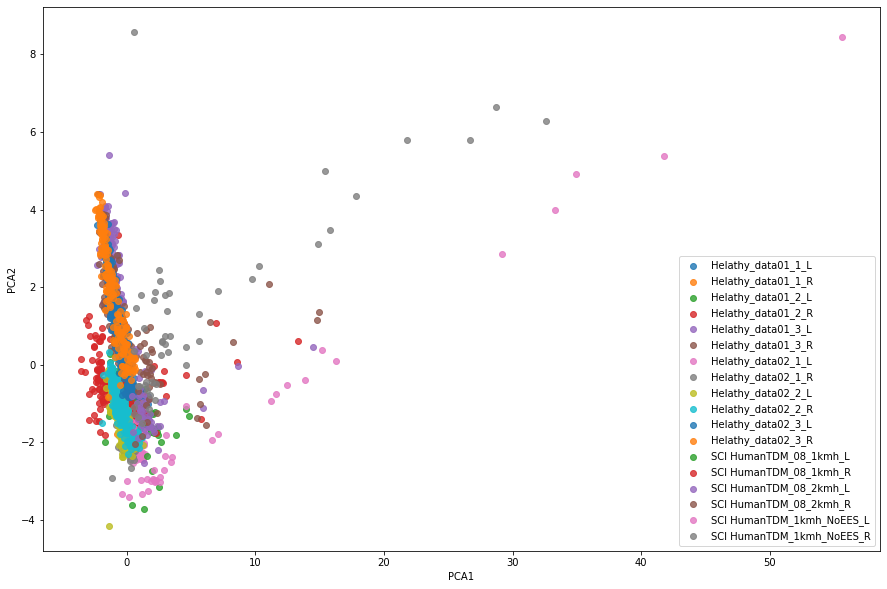

In [38]:
pca = PCA(n_components=2)
PCA_data = pca.fit_transform(scale(merged_data.drop(["label","foot","condition"],axis=1)))

color_plot(PCA_data,np.array(merged_data["label"]))

print("PCA1: ", pca.explained_variance_ratio_[0])
print("PCA2: ", pca.explained_variance_ratio_[1])

loadings = pca.components_.T * np.sqrt(pca.explained_variance_)

loading_matrix = pd.DataFrame(loadings, columns=['PC1', 'PC2'], index=list(merged_data.drop(["label","foot","condition"],axis=1).columns))
loading_matrix

PCA1:  0.43249559886631384
PCA2:  0.18917291602194453


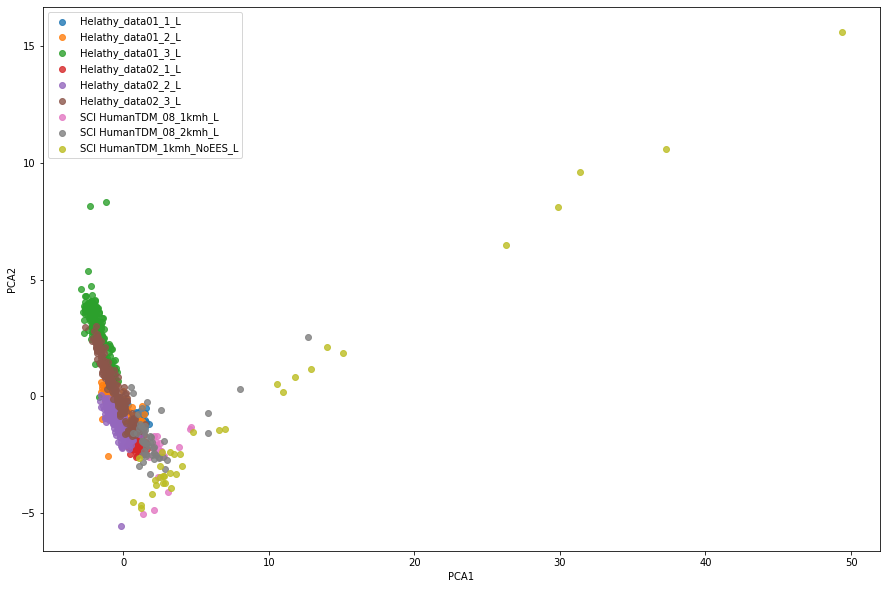

In [39]:
pca = PCA(n_components=2)
PCA_data = pca.fit_transform(scale(merged_data_L.drop(["label","foot","condition"],axis=1)))

color_plot(PCA_data,np.array(merged_data_L["label"]))

print("PCA1: ", pca.explained_variance_ratio_[0])
print("PCA2: ", pca.explained_variance_ratio_[1])

loadings = pca.components_.T * np.sqrt(pca.explained_variance_)

loading_matrix = pd.DataFrame(loadings, columns=['PC1', 'PC2'], index=list(merged_data.drop(["label","foot","condition"],axis=1).columns))
loading_matrix

PCA1:  0.40878924157169017
PCA2:  0.123559533128026
Variance ratios  [0.40878924 0.12355953]


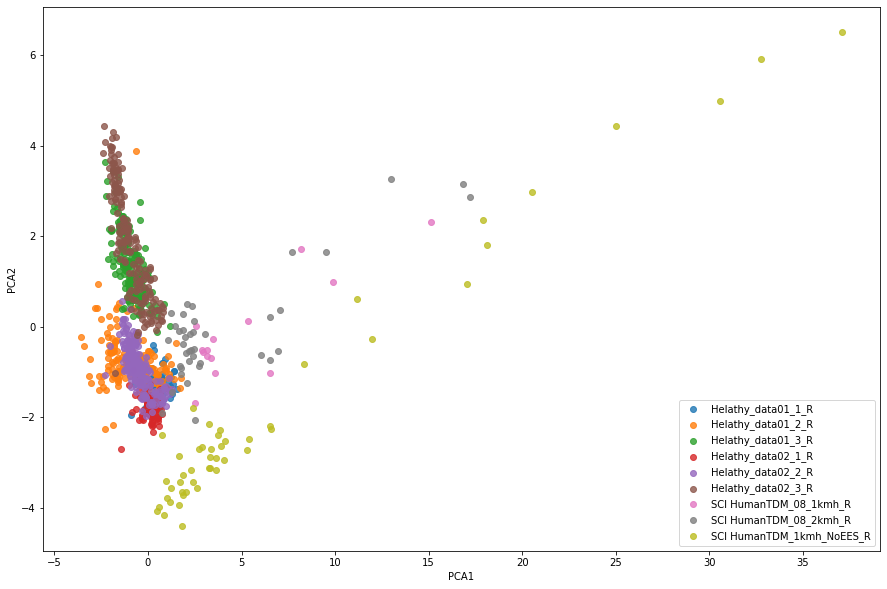

In [40]:
pca = PCA(n_components=2)
PCA_data = pca.fit_transform(scale(merged_data_R.drop(["label","foot","condition"],axis=1)))

color_plot(PCA_data,np.array(merged_data_R["label"]))

print("PCA1: ", pca.explained_variance_ratio_[0])
print("PCA2: ", pca.explained_variance_ratio_[1])
print("Variance ratios ", pca.explained_variance_ratio_)

loadings = pca.components_.T * np.sqrt(pca.explained_variance_)

loading_matrix = pd.DataFrame(loadings, columns=['PC1', 'PC2'], index=list(merged_data.drop(["label","foot","condition"],axis=1).columns))
loading_matrix

PCA1:  0.40638112837865403
PCA2:  0.14089216519967285


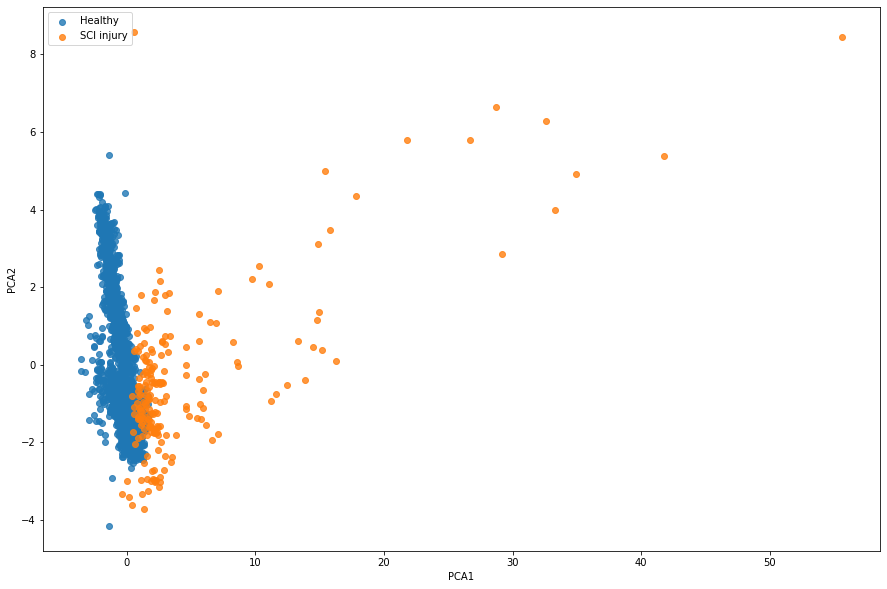

In [41]:
pca = PCA(n_components=2)
PCA_data = pca.fit_transform(scale(merged_data.drop(["label","foot","condition"],axis=1)))

color_plot(PCA_data,np.array(merged_data["condition"]))

print("PCA1: ", pca.explained_variance_ratio_[0])
print("PCA2: ", pca.explained_variance_ratio_[1])

loadings = pca.components_.T * np.sqrt(pca.explained_variance_)

loading_matrix = pd.DataFrame(loadings, columns=['PC1', 'PC2'], index=list(merged_data.drop(["label","foot","condition"],axis=1).columns))
loading_matrix

In [42]:
pca = PCA(n_components=3)
PCA_data = pca.fit_transform(scale(merged_data.drop(["label","foot","condition"],axis=1)))



PCA_data = pd.DataFrame(PCA_data).rename(columns = {0:'PCA1', 1:'PCA2', 2: "PCA3"})
PCA_data["condition"] = np.array(merged_data["condition"])
fig = px.scatter_3d(PCA_data, x="PCA1", y="PCA2", z="PCA3",
              color='condition')
fig.update_traces(marker=dict(size=3))
fig.show()

print("PCA1: ", pca.explained_variance_ratio_[0])
print("PCA2: ", pca.explained_variance_ratio_[1])
print("PCA3: ", pca.explained_variance_ratio_[2])

loadings = pca.components_.T * np.sqrt(pca.explained_variance_)

loading_matrix = pd.DataFrame(loadings, columns=['PC1', 'PC2', 'PC3'], index=list(merged_data.drop(["label","foot","condition"],axis=1).columns))
loading_matrix

PCA1:  0.4063811283786542
PCA2:  0.14089216519966297
PCA3:  0.11123014255231356


,PC1,PC2,PC3
swing_duration,-0.189516,-0.029528,-0.270615
stance_duration,0.818165,0.104009,0.090723
max_knee_angle,-0.326234,0.313171,-0.339365
min_knee_angle,0.313123,0.367002,0.428886
max_ankle_angle,-0.398309,0.543748,-0.232226
min_ankle_angle,-0.317705,-0.178484,-0.730601
max_hip_angle,-0.095761,0.281302,-0.111929
min_hip_angle,0.304009,-0.494714,0.395537
var_foot,-0.010006,0.611340,0.620444
max_ankle_anlge_v,0.329259,0.216573,0.822190


In [43]:
pca = PCA(n_components=3)
PCA_data = pca.fit_transform(scale(merged_data.drop(["label","foot","condition"],axis=1)))

PCA_data = pd.DataFrame(PCA_data).rename(columns = {0:'PCA1', 1:'PCA2', 2: "PCA3"})
PCA_data["condition"] = np.array(merged_data["label"])
fig = px.scatter_3d(PCA_data, x="PCA1", y="PCA2", z="PCA3",
              color='condition', size_max=5)
fig.update_traces(marker=dict(size=3))
fig.show()

print("PCA1: ", pca.explained_variance_ratio_[0])
print("PCA2: ", pca.explained_variance_ratio_[1])
print("PCA3: ", pca.explained_variance_ratio_[2])

loadings = pca.components_.T * np.sqrt(pca.explained_variance_)

loading_matrix = pd.DataFrame(loadings, columns=['PC1', 'PC2', 'PC3'], index=list(merged_data.drop(["label","foot","condition"],axis=1).columns))
loading_matrix

PCA1:  0.4063811283786533
PCA2:  0.14089216519966946
PCA3:  0.11123014255096884


,PC1,PC2,PC3
swing_duration,-0.189516,-0.029528,-0.270615
stance_duration,0.818165,0.104009,0.090723
max_knee_angle,-0.326234,0.313171,-0.339365
min_knee_angle,0.313123,0.367002,0.428885
max_ankle_angle,-0.398309,0.543749,-0.232226
min_ankle_angle,-0.317705,-0.178484,-0.730601
max_hip_angle,-0.095761,0.281302,-0.111929
min_hip_angle,0.304009,-0.494714,0.395537
var_foot,-0.010006,0.611340,0.620443
max_ankle_anlge_v,0.329259,0.216573,0.822191


In [44]:
pca = PCA(n_components=3)
PCA_data = pca.fit_transform(scale(merged_data_L.drop(["label","foot","condition"],axis=1)))

PCA_data = pd.DataFrame(PCA_data).rename(columns = {0:'PCA1', 1:'PCA2', 2: "PCA3"})
PCA_data["condition"] = np.array(merged_data_L["label"])
fig = px.scatter_3d(PCA_data, x="PCA1", y="PCA2", z="PCA3",
              color='condition', size_max=5)
fig.update_traces(marker=dict(size=3))
fig.show()

print("PCA1: ", pca.explained_variance_ratio_[0])
print("PCA2: ", pca.explained_variance_ratio_[1])
print("PCA3: ", pca.explained_variance_ratio_[2])

loadings = pca.components_.T * np.sqrt(pca.explained_variance_)

loading_matrix = pd.DataFrame(loadings, columns=['PC1', 'PC2', 'PC3'], index=list(merged_data.drop(["label","foot","condition"],axis=1).columns))
loading_matrix

PCA1:  0.432495598866315
PCA2:  0.18917291602194394
PCA3:  0.0995036197345478


,PC1,PC2,PC3
swing_duration,-0.221179,0.225434,-0.504485
stance_duration,0.929331,0.120338,0.176805
max_knee_angle,-0.486937,0.603506,-0.242620
min_knee_angle,0.310646,0.123192,0.523068
max_ankle_angle,-0.425528,0.573599,0.289107
min_ankle_angle,0.063523,-0.292575,0.608816
max_hip_angle,-0.274568,0.394943,-0.538169
min_hip_angle,0.337258,-0.465833,-0.073099
var_foot,-0.490834,0.794445,0.039198
max_ankle_anlge_v,0.167812,0.394784,-0.090374


In [46]:
pca = PCA(n_components=3)
PCA_data = pca.fit_transform(scale(merged_data_R.drop(["label","foot","condition"],axis=1)))


PCA_data = pd.DataFrame(PCA_data).rename(columns = {0:'PCA1', 1:'PCA2', 2: "PCA3"})
PCA_data["condition"] = np.array(merged_data_R["label"])
fig = px.scatter_3d(PCA_data, x="PCA1", y="PCA2", z="PCA3",
              color='condition', size_max=5)
fig.update_traces(marker=dict(size=3))
fig.show()

print("PCA1: ", pca.explained_variance_ratio_[0])
print("PCA2: ", pca.explained_variance_ratio_[1])
print("PCA3: ", pca.explained_variance_ratio_[2])

loadings = pca.components_.T * np.sqrt(pca.explained_variance_)

loading_matrix = pd.DataFrame(loadings, columns=['PC1', 'PC2', 'PC3'], index=list(merged_data.drop(["label","foot","condition"],axis=1).columns))
loading_matrix

PCA1:  0.40878924157169105
PCA2:  0.1235595331279802
PCA3:  0.11951919746222602


,PC1,PC2,PC3
swing_duration,-0.198319,-0.107037,-0.382994
stance_duration,0.726750,0.162232,0.200922
max_knee_angle,-0.308450,0.246812,-0.258777
min_knee_angle,0.354465,0.217251,0.658160
max_ankle_angle,-0.447676,0.540847,0.112715
min_ankle_angle,-0.583324,0.180884,-0.578450
max_hip_angle,-0.013685,0.225706,-0.070344
min_hip_angle,0.317626,-0.682972,0.236446
var_foot,0.262365,0.150889,0.783472
max_ankle_anlge_v,0.500003,-0.200337,0.751137
